In [76]:
from sirf.STIR import (ImageData, AcquisitionData,
                       SPECTUBMatrix, AcquisitionModelUsingMatrix,
                       make_Poisson_loglikelihood, OSMAPOSLReconstructor,
                       SeparableGaussianImageFilter, MessageRedirector,
)
from simind import *
import pandas as pd
import matplotlib.pyplot as plt

In [77]:
current_directory = os.getcwd()
current_directory

'/home/sam/working/STIR_users_MIC2023'

In [78]:
msg = MessageRedirector()
AcquisitionData.set_storage_scheme('memory')

In [79]:
# SIMIND parameters
total_activity = 258.423 # MBq
time_per_projection = 43 # seconds
photon_multiplier = 0.01
photopeak_energy = 208 # keV
window_lower = 187.56 # keV
window_upper = 229.24 # keV
source_type = "lu177" 
collimator = 'ma-megp'
kev_per_channel = 1
num_energy_spectra_channels = 300

# OSEM parameters
iterations = 5
subsets = 12

In [80]:
template_image = ImageData(os.path.join(os.getcwd(), "data/Lu177/SPECT_NEMA_Lu177_template.hv"))
mu_map = ImageData(os.path.join(os.getcwd(), "data/Lu177/registered_CTAC.hv"))

measured_data = AcquisitionData(os.path.join(os.getcwd(), "data/Lu177/SPECTCT_NEMA_128_EM001_DS_en_1_Lu177_EM.hdr"))

In [81]:
mu_map_stir = mu_map.clone()
mu_map_stir.fill(np.flip(mu_map_stir.as_array(), axis=2))

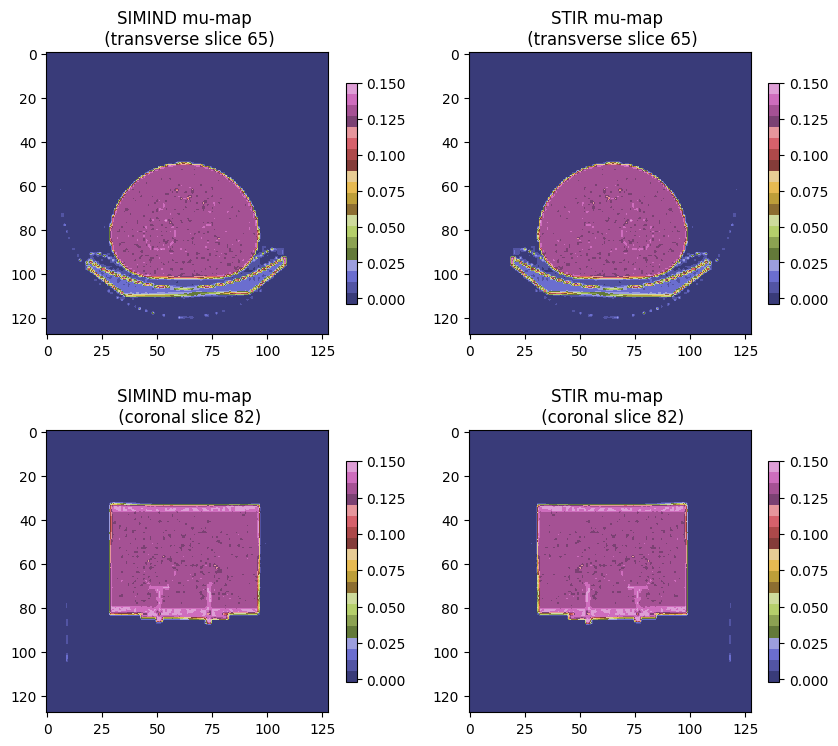

In [82]:
axial_slice = 65
coronal_slice = 82

vmax = 0.15

fig, ax = plt.subplots(2, 2, figsize=(10, 9))
ax0 = ax[0,0].imshow(mu_map.as_array()[axial_slice, :, :], cmap='tab20b', vmax=vmax)
ax[0,0].set_title(f"SIMIND mu-map \n (transverse slice {axial_slice})")
fig.colorbar(ax0, ax=ax[0,0], shrink=0.7)
ax1 = ax[0,1].imshow(mu_map_stir.as_array()[axial_slice, :, :], cmap='tab20b', vmax=vmax)
ax[0,1].set_title(f"STIR mu-map \n (transverse slice {axial_slice})")
fig.colorbar(ax1, ax=ax[0,1], shrink=0.7)
ax2 = ax[1,0].imshow(mu_map.as_array()[:, coronal_slice, :], cmap='tab20b', vmax=vmax)
ax[1,0].set_title(f"SIMIND mu-map \n (coronal slice {coronal_slice})")
fig.colorbar(ax2, ax=ax[1,0], shrink=0.7)
ax3 = ax[1,1].imshow(mu_map_stir.as_array()[:, coronal_slice, :], cmap='tab20b', vmax=vmax)
ax[1,1].set_title(f"STIR mu-map \n (coronal slice {coronal_slice})")
fig.colorbar(ax3, ax=ax[1,1], shrink=0.7)

In [83]:
acq_matrix = SPECTUBMatrix()
acq_matrix.set_attenuation_image(mu_map_stir)
acq_matrix.set_keep_all_views_in_cache(True)
acq_matrix.set_resolution_model(1.81534, 0.02148, False)
acq_model = AcquisitionModelUsingMatrix(acq_matrix)
acq_model.set_up(measured_data, template_image)

In [84]:
def divide(a,b, eps=1e-8):
    return (a+eps)/(b+eps) 

def osem_step(acq_model, acq_data, current_image, sensitivity_image, scatter):
    fp = acq_model.forward(current_image) + scatter
    bpr = acq_model.backward(divide(acq_data, fp))
    return divide(current_image * bpr, sensitivity_image)

def run_osem(acq_model, acq_data, initial_image, iterations, subsets, scatter = 0):
    current_image = initial_image.clone()
    sensitivity_images = []
    one_sino = acq_data.get_uniform_copy(1)
    for i in range(iterations):
        for s in range(subsets):
            acq_model.subset_num = s
            if len(sensitivity_images) < subsets:
                sensitivity_images.append(acq_model.backward(one_sino))
            current_image = osem_step(acq_model, acq_data, current_image, sensitivity_images[s], scatter)
            print(f"Completed iteration {i+1} of {iterations}, subset {s+1} of {subsets}")
    return current_image

In [85]:
acq_model.num_subsets = subsets

osem_reconstruction = run_osem(acq_model, measured_data, template_image.get_uniform_copy(1), iterations, subsets)

backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 1 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 2 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 3 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 4 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 5 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 6 of 12
backprojecting...ok
no additive term added
no unnorm

In [86]:
osem_reconstruction_postfilter = osem_reconstruction.clone()

gaussian_filter = SeparableGaussianImageFilter()
gaussian_filter.set_fwhms((5, 5, 5))
gaussian_filter.apply(osem_reconstruction_postfilter)

osem_reconstruction_postfilter_array = osem_reconstruction_postfilter.as_array()
osem_reconstruction_postfilter_array[osem_reconstruction_postfilter_array < 0.1 * osem_reconstruction_postfilter.max()] = 0
osem_reconstruction_postfilter.fill(osem_reconstruction_postfilter_array)

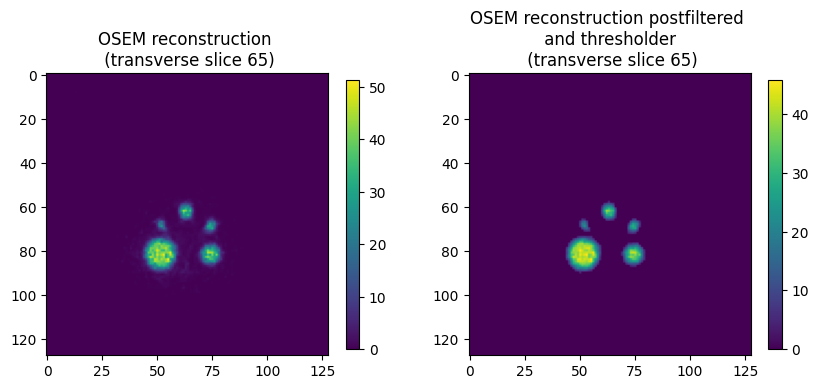

In [87]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax0 = ax[0].imshow(osem_reconstruction.as_array()[axial_slice, :, :])
ax[0].set_title(f"OSEM reconstruction \n (transverse slice {axial_slice})")
fig.colorbar(ax0, ax=ax[0], shrink=0.7)
ax1 = ax[1].imshow(osem_reconstruction_postfilter.as_array()[axial_slice, :, :])
ax[1].set_title(f"OSEM reconstruction postfiltered \n and thresholder \n (transverse slice {axial_slice})")
fig.colorbar(ax1, ax=ax[1], shrink=0.7)

In [88]:
create_window_file(lower_bounds=window_lower, upper_bounds=window_upper, scatter_orders=0, output_filename= "input.win")

In [89]:
simulator = SimindSimulator(input_filepath=".", output_filepath=".",)
attributes = {"SourceMap": osem_reconstruction_postfilter,
              "MuMap": mu_map,
              "keVPerChannel": kev_per_channel, 
              'NumberOfEnergySpectraChannels': num_energy_spectra_channels,
              "PhotopeakEnergy": photopeak_energy,
              "SourceActivity": total_activity,
              "PhotonMultiplier": photon_multiplier,
              "ImageDurationPerProjection": time_per_projection,
              "SourceType": source_type.lower(),
              "Collimator": collimator,}
simulator.set_template_sinogram(measured_data)
simulator.set_attributes(attributes)

In [90]:
simulator.run_simulation()

Clearing all files in . that could cause trouble...
This includes:
 - .h00, .hs, .a00, .hct, .ict, .bis, .res
if this is not what you want, please cancel this process now.
5
4
3
2
1
removed output_air_w1.a00
removed output.res
removed output_air_w1.h00
removed output_tot_w1.h00
removed output.bis
removed output_tot_w1.hs
removed output_sca_w1.h00
removed tmp_adjus_adjusted.h00
removed output_sca_w2.h00
removed tmp.hs
removed output_sca_w2.hs
removed output_sca_w2.a00
removed output_tot_w1.a00
removed output_sca_w1.a00
removed output_air_w1.hs
removed output_sca_w1.hs
All required attributes are set and ready for simulation.
All relevant files exist in ..
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists
symlink already exists



              SIMIND Monte Carlo Si

In [91]:
simind_total = simulator.get_output_total()
simind_scatter = simulator.get_output_scatter()
simind_true = simind_total - simind_scatter

Output in ./output_air_w1.hs

Output in ./output_tot_w1.hs

Output in ./output_sca_w1.hs

Output in ./output_sca_w2.hs






In [92]:
stir_projection = measured_data.get_uniform_copy(0)
for i in range(subsets):
    acq_model.subset_num = i
    stir_projection+=acq_model.forward(osem_reconstruction_postfilter)

no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added
no additive term added
no unnormalisation applied
no background term added


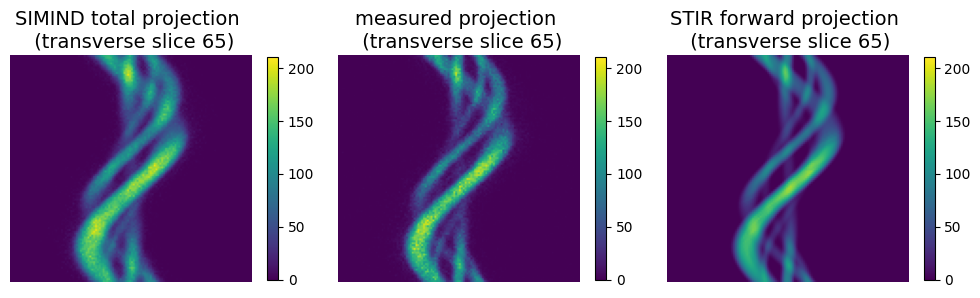

In [93]:
# Define consistent font size and colormap
font_size = 14
colormap = 'viridis'

vmin = 0
vmax = max(measured_data.max(), simind_total.max(), stir_projection.max())

data_list = [
    (simind_total.as_array()[0, axial_slice, :, :], "SIMIND total projection"),
    (measured_data.as_array()[0, axial_slice, :, :], "measured projection"),
    (stir_projection.as_array()[0, axial_slice, :, :], "STIR forward projection")
]

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

for i, (data, title) in enumerate(data_list):
    im = ax[i].imshow(data, vmin=vmin, vmax=vmax, cmap=colormap)
    ax[i].set_title(f"{title} \n (transverse slice {axial_slice})", fontsize=font_size)
    ax[i].axis('off')  # Remove axis ticks and labels
    fig.colorbar(im, ax=ax[i], shrink=0.6)

# Adjust spacing
plt.tight_layout()
plt.show()

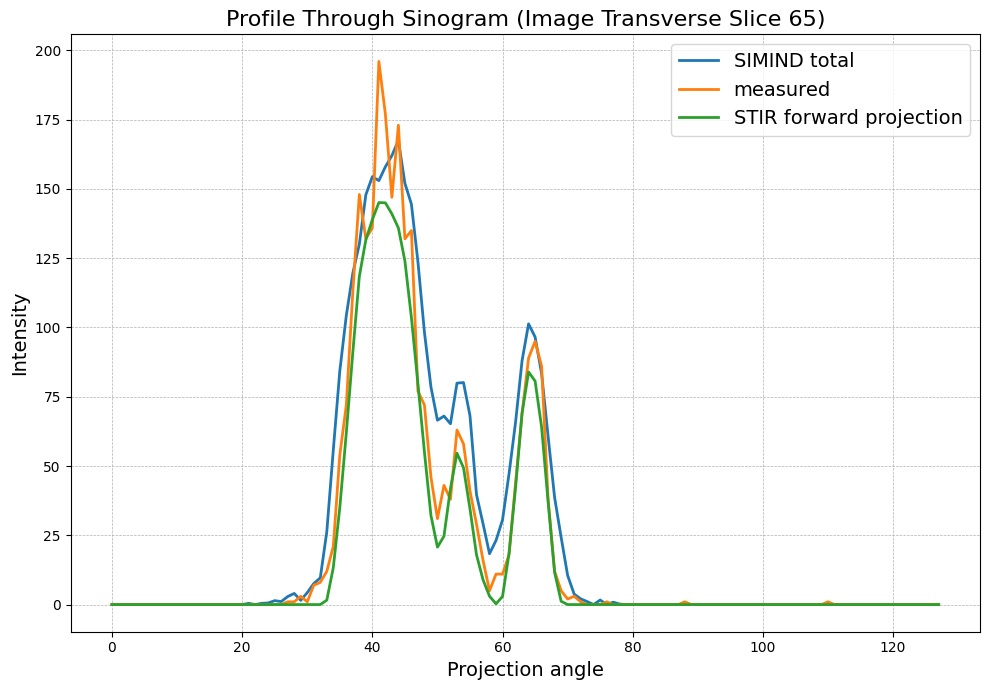

In [94]:
# Set consistent font size and line width
font_size = 14
line_width = 2

# Extract data
simind_data = simind_total.as_array()[0,axial_slice, 100, :]
measured_data_vals = measured_data.as_array()[0,axial_slice, 100, :]
stir_data = stir_projection.as_array()[0,axial_slice, 100, :]

# Plotting
plt.figure(figsize=(10, 7))  # Adjust size for better visibility

plt.plot(simind_data, label="SIMIND total", linewidth=line_width)
plt.plot(measured_data_vals, label="measured", linewidth=line_width)
plt.plot(stir_data, label="STIR forward projection", linewidth=line_width)

# Enhance the appearance
plt.xlabel('Projection angle', fontsize=font_size)
plt.ylabel('Intensity', fontsize=font_size)
plt.title(f'Profile Through Sinogram (Image Transverse Slice {axial_slice})', fontsize=font_size + 2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right', fontsize=font_size)
plt.tight_layout()

plt.show()

In [115]:
print(f"SIMIND total counts: {simind_total.sum()}")
print(f"Measured counts: {measured_data.sum()}")
print(f"STIR forward projection counts: {stir_projection.sum()}")

SIMIND total counts: 3760306.25
Measured counts: 2744865.0
STIR forward projection counts: 1855937.125


In [96]:
measured_counts = measured_data.sum()
simind_counts = simind_total.sum()

simind_true_normalised = simind_true * measured_counts/simind_counts
simind_total_normalised = simind_total * measured_counts/simind_counts
simind_scatter_normalised = simind_scatter * measured_counts/simind_counts

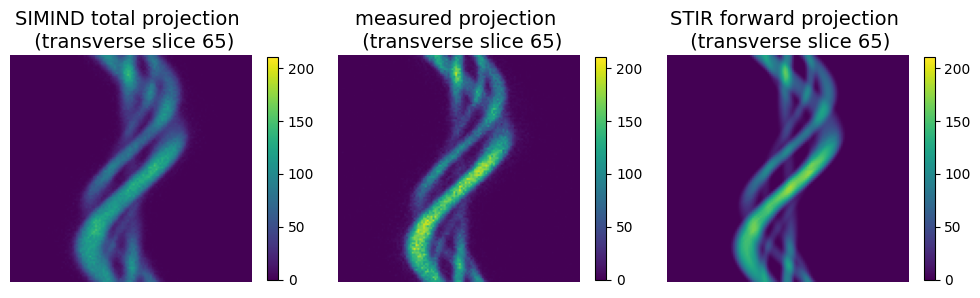

In [97]:
# Define consistent font size and colormap
font_size = 14
colormap = 'viridis'

vmin = 0
vmax = max(measured_data.max(), simind_total_normalised.max(), stir_projection.max())

data_list = [
    (simind_total_normalised.as_array()[0, axial_slice, :, :], "SIMIND total projection"),
    (measured_data.as_array()[0, axial_slice, :, :], "measured projection"),
    (stir_projection.as_array()[0, axial_slice, :, :], "STIR forward projection")
]

fig, ax = plt.subplots(1, 3, figsize=(10, 4))

for i, (data, title) in enumerate(data_list):
    im = ax[i].imshow(data, vmin=vmin, vmax=vmax, cmap=colormap)
    ax[i].set_title(f"{title} \n (transverse slice {axial_slice})", fontsize=font_size)
    ax[i].axis('off')  # Remove axis ticks and labels
    fig.colorbar(im, ax=ax[i], shrink=0.6)

# Adjust spacing
plt.tight_layout()
plt.show()

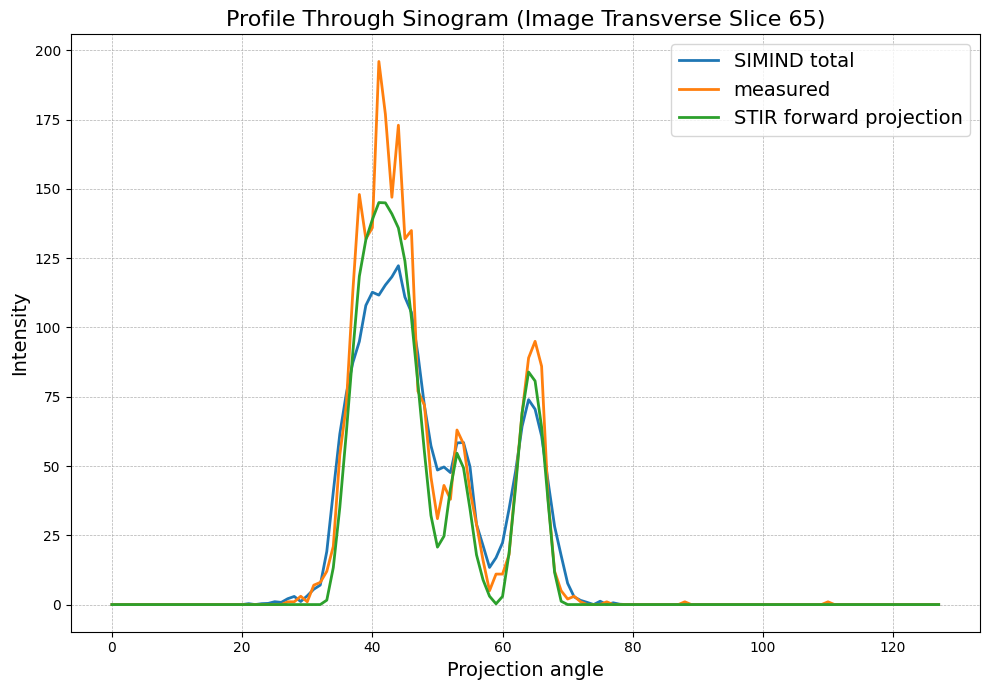

In [98]:
# Set consistent font size and line width
font_size = 14
line_width = 2

# Extract data
simind_data = simind_total_normalised.as_array()[0,axial_slice, 100, :]
measured_data_vals = measured_data.as_array()[0,axial_slice, 100, :]
stir_data = stir_projection.as_array()[0,axial_slice, 100, :]

# Plotting
plt.figure(figsize=(10, 7))  # Adjust size for better visibility

plt.plot(simind_data, label="SIMIND total", linewidth=line_width)
plt.plot(measured_data_vals, label="measured", linewidth=line_width)
plt.plot(stir_data, label="STIR forward projection", linewidth=line_width)

# Enhance the appearance
plt.xlabel('Projection angle', fontsize=font_size)
plt.ylabel('Intensity', fontsize=font_size)
plt.title(f'Profile Through Sinogram (Image Transverse Slice {axial_slice})', fontsize=font_size + 2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right', fontsize=font_size)
plt.tight_layout()

plt.show()

In [114]:
print(f"SIMIND total counts: {simind_total_normalised.sum()}")
print(f"Measured counts: {measured_data.sum()}")
print(f"STIR forward projection counts: {stir_projection.sum()}")

SIMIND total counts: 2744865.25
Measured counts: 2744865.0
STIR forward projection counts: 1855937.125


In [100]:
lower = AcquisitionData("//home/sam/data/Stathis_NEMA/data/SPECTCT_NEMA_128_SC1001_DS_en_1_Lu177_SC.hdr")
upper = AcquisitionData("/home/sam/data/Stathis_NEMA/data/SPECTCT_NEMA_128_SC2001_DS_en_1_Lu177_SC.hdr")

lower_window_size = 187.46 - 176.54
upper_window_size = 243.49 -  229.31
primary_window_size = 229.24 - 187.56

scatter_tew = (lower * (primary_window_size / lower_window_size)) - (upper * (primary_window_size / upper_window_size))
scatter_dew = (lower * (primary_window_size / lower_window_size))
corrected_tew = measured_data - scatter_tew
corrected_dew = measured_data - scatter_dew


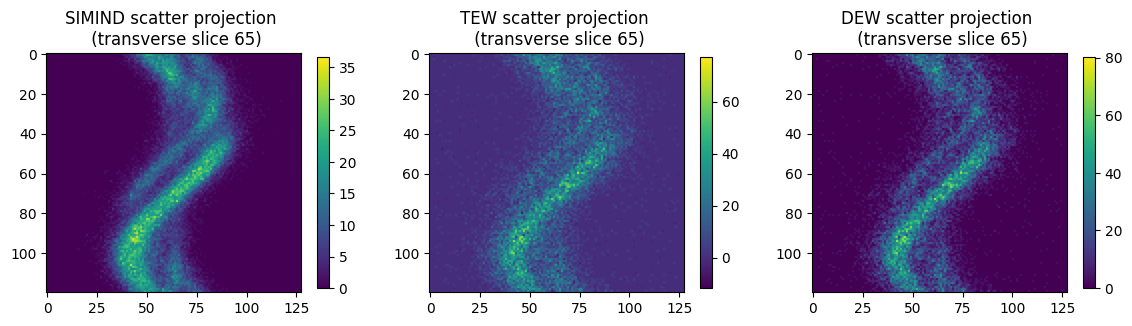

In [101]:
fig, ax = plt.subplots(1, 3, figsize=(14, 5))
ax0 = ax[0].imshow(simind_scatter_normalised.as_array()[0,axial_slice, :, :])
ax[0].set_title(f"SIMIND scatter projection \n (transverse slice {axial_slice})")
fig.colorbar(ax0, ax=ax[0], shrink=0.6)
ax1 = ax[1].imshow(scatter_tew.as_array()[0,axial_slice, :, :])
ax[1].set_title(f"TEW scatter projection \n (transverse slice {axial_slice})")
fig.colorbar(ax1, ax=ax[1], shrink=0.6)
ax2 = ax[2].imshow(scatter_dew.as_array()[0,axial_slice, :, :])
ax[2].set_title(f"DEW scatter projection \n (transverse slice {axial_slice})")
fig.colorbar(ax2, ax=ax[2], shrink=0.6)

In [102]:
osem_reconstruction_with_simind_scatter_correction = run_osem(acq_model, measured_data, template_image.get_uniform_copy(1), iterations, subsets, scatter = simind_scatter_normalised)

backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 1 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 2 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 3 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 4 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 5 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 6 of 12
backprojecting...ok
no additive term added
no unnorm

In [103]:
measured_data_tew_corrected = AcquisitionData(os.path.join(os.getcwd(), "data/Lu177/STIR_TEW.hs"))
osem_reconstruction_with_tew_scatter_correction = run_osem(acq_model, measured_data_tew_corrected.maximum(0), template_image.get_uniform_copy(1), iterations, subsets)

backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 1 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 2 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 3 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 4 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 5 of 12
backprojecting...ok
no additive term added
no unnormalisation applied
no background term added
backprojecting...ok
Completed iteration 1 of 5, subset 6 of 12
backprojecting...ok
no additive term added
no unnorm

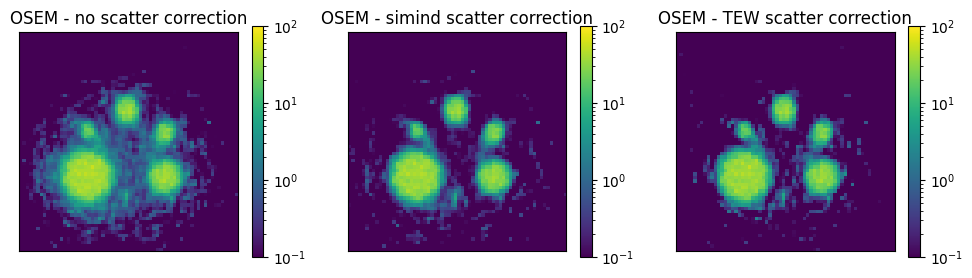

In [104]:
from matplotlib.colors import LogNorm

# round osem_max up to the nearest power of 10
osem_max = 10 ** np.ceil(np.log10(osem_reconstruction.max()))

# Lu177 [65, 40:104, 32:96]

slice = 66
vmin = 0.1

# same as above but highlight lower values with inverse log scale
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax0 = ax[0].imshow(osem_reconstruction.as_array()[slice, 40:104, 32:96], norm=LogNorm(vmin=vmin, vmax=osem_max))
ax[0].set_title("OSEM - no scatter correction")
ax1 = ax[1].imshow(osem_reconstruction_with_simind_scatter_correction.as_array()[slice, 40:104, 32:96], norm=LogNorm(vmin=vmin, vmax=osem_max))
ax[1].set_title("OSEM - simind scatter correction")
ax3 = ax[2].imshow(osem_reconstruction_with_tew_scatter_correction.as_array()[slice, 40:104, 32:96], norm=LogNorm(vmin=vmin, vmax=osem_max))
ax[2].set_title("OSEM - TEW scatter correction")
fig.colorbar(ax0, ax=ax[0], shrink=0.6)
fig.colorbar(ax1, ax=ax[1], shrink=0.6)
fig.colorbar(ax3, ax=ax[2], shrink=0.6)


# draw spheres on images to show where the spheres are
# sphere diams are 60, 37, 28, 22, 17, 13 mm
from matplotlib.patches import Circle

# sphere centres in pixels - Lu177
centres = [(19.5, 42), (42.5, 41.5), (31, 22), (42.5, 28.5), (20, 28.5), (31, 48)]
# sphere radii in pixels
pixel_size = template_image.voxel_sizes()[0] # assume isotropic voxels (which we know they are)
diams = [60, 37, 28, 22, 17, 13]
radii = [d / pixel_size /2 for d in diams]

for i, a in enumerate(ax):
    for c, r in zip(centres, radii):
        circ = Circle(c, r, color="r", fill=False)
        #a.add_patch(circ)

# remove ticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

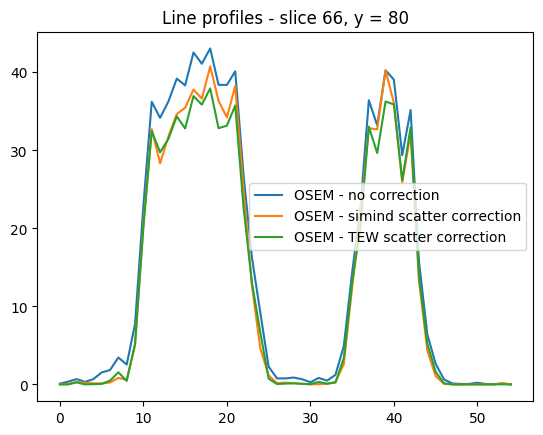

In [105]:
# line profiles
plt.plot(osem_reconstruction.as_array()[slice, 82, 35:90], label="OSEM - no correction")
plt.plot(osem_reconstruction_with_simind_scatter_correction.as_array()[slice, 82, 35:90], label="OSEM - simind scatter correction")
plt.plot(osem_reconstruction_with_tew_scatter_correction.as_array()[slice, 82, 35:90], label="OSEM - TEW scatter correction")
plt.legend()
plt.title("Line profiles - slice 66, y = 80")
plt.show()

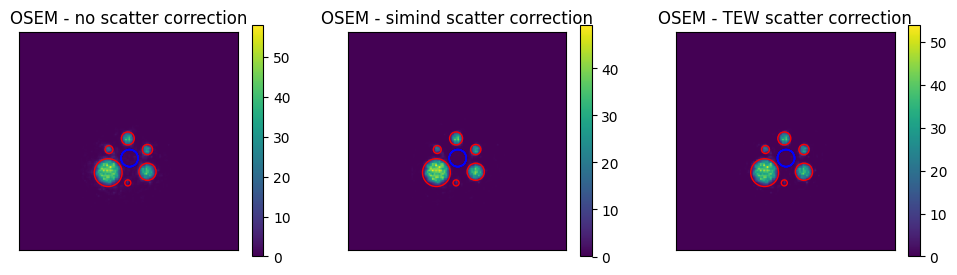

In [106]:
# round osem_max up to the nearest power of 10
osem_max = 10 ** np.ceil(np.log10(osem_reconstruction.max()))

slice = 66
vmin = 0.1

# same as above but highlight lower values with inverse log scale
fig, ax = plt.subplots(1, 3, figsize=(12, 5))
ax0 = ax[0].imshow(osem_reconstruction.as_array()[slice])
ax[0].set_title("OSEM - no scatter correction")
ax1 = ax[1].imshow(osem_reconstruction_with_simind_scatter_correction.as_array()[slice])
ax[1].set_title("OSEM - simind scatter correction")
ax3 = ax[2].imshow(osem_reconstruction_with_tew_scatter_correction.as_array()[slice])
ax[2].set_title("OSEM - TEW scatter correction")
fig.colorbar(ax0, ax=ax[0], shrink=0.6)
fig.colorbar(ax1, ax=ax[1], shrink=0.6)
fig.colorbar(ax3, ax=ax[2], shrink=0.6)


# draw spheres on images to show where the spheres are
# sphere diams are 60, 37, 28, 22, 17, 13 mm
from matplotlib.patches import Circle

centres2 = [(c[0]+32, c[1]+40) for c in centres]
centres_bg = (32+32, 40+33.5)
radii2 = radii.copy()
radius_bg = 5

for i, a in enumerate(ax):
    for c, r in zip(centres2, radii2):
        circ = Circle(c, r*1.2, color="r", fill=False)
        a.add_patch(circ)
        circ = Circle(centres_bg, radius_bg, color="b", fill=False)
        a.add_patch(circ)

# remove ticks
for a in ax:
    a.set_xticks([])
    a.set_yticks([])

In [107]:
# some functions for calculating metrics

def sphere_mask(arr_shape, center, radius):
    z, y, x = np.ogrid[:arr_shape[0], :arr_shape[1], :arr_shape[2]]
    dist_sq = (x - center[2])**2 + (y - center[1])**2 + (z - center[0])**2
    return dist_sq <= radius**2

def mean_activity_conc_in_sphere(arr, center, radius, voxel_size, calibration_factor):
    mask = sphere_mask(arr.shape, center, radius)
    mean_count_per_vox = np.mean(arr[mask])
    return mean_count_per_vox / ((voxel_size/10)**3) / calibration_factor

def total_activity_in_sphere(arr, center, radius, calibration_factor):
    mask = sphere_mask(arr.shape, center, radius)
    counts = np.sum(arr[mask])
    return counts / calibration_factor

def standard_deviation_in_sphere(arr, center, radius, voxel_size, calibration_factor):
    mask = sphere_mask(arr.shape, center, radius)
    std_count_per_vox = np.std(arr[mask])
    return std_count_per_vox / ((voxel_size/10)**3) / calibration_factor

def SNR(arr, center, radius, voxel_size, calibration_factor):
    signal = mean_activity_conc_in_sphere(arr, center, radius, voxel_size, calibration_factor)
    noise_std = standard_deviation_in_sphere(arr, center, radius, voxel_size, calibration_factor)
    return signal / noise_std

def CNR(arr, center_obj, radius_obj, center_bg, radius_bg, voxel_size, calibration_factor):
    signal_obj = mean_activity_conc_in_sphere(arr, center_obj, radius_obj, voxel_size, calibration_factor)
    signal_bg = mean_activity_conc_in_sphere(arr, center_bg, radius_bg, voxel_size, calibration_factor)
    noise_std_bg = standard_deviation_in_sphere(arr, center_bg, radius_bg, voxel_size, calibration_factor)
    return (signal_obj - signal_bg) / noise_std_bg

calibration_factor = 0.0472 # Counts per second per MBq = counts / acquisition time / activity
calibration_factor*= (time_per_projection * measured_data.dimensions()[2]) # counts per MBq
activity_concentration = 1.611 # MBq/ml
activity_concentraion_voxel = activity_concentration * template_image.voxel_sizes()[0] * template_image.voxel_sizes()[1] * template_image.voxel_sizes()[2] # MBq / voxel

radii_150percent = [r * 1.5 for r in radii] # to include spillout
radii_75percent = [r * 0.75 for r in radii]
radii_50percent = [r * 0.5 for r in radii]

centres_3d = [(slice, c[1]+40, c[0]+32) for c in centres] # centres for full 3D array
centre_bg_3d = (slice, 40+33.5, 32+32) # centre for full 3D

expected_sphere_activity = [activity_concentration * 4/3 * np.pi * (d/2/10)**3 for d in diams]

In [108]:
def calculate_metrics(arr, center, radius, voxel_sizes, calibration_factor, bg_center, bg_radius):
    voxel_volume = voxel_sizes[0] * voxel_sizes[1] * voxel_sizes[2] # ml
    voxel_size_mm = np.mean(voxel_sizes) # assuming voxels are approximately cubic
    
    total_activity = total_activity_in_sphere(arr, center, radius, calibration_factor)
    activity_conc = mean_activity_conc_in_sphere(arr, center, radius, voxel_size_mm, calibration_factor)
    snr = SNR(arr, center, radius, voxel_size_mm, calibration_factor)
    cnr = CNR(arr, center, radius, bg_center, bg_radius, voxel_size_mm, calibration_factor)
    
    return total_activity, activity_conc, snr, cnr


In [109]:
reconstructions = {
    'OSEM': osem_reconstruction.as_array(),
    'OSEM with Simind Scatter': osem_reconstruction_with_simind_scatter_correction.as_array(),
    'OSEM with TEW Scatter': osem_reconstruction_with_tew_scatter_correction.as_array()
}

# Lists of metrics and radii
radii_list = [radii, radii_75percent, radii_50percent, radii_150percent]
radii_names = ["Original", "75%", "50%", "150%"]

# Initialize empty list for storing dataframes
dfs = []

# Iterate for each radii
for rad, rad_name in zip(radii_list, radii_names):
    
    # Create a temporary dictionary to build dataframe
    data = {}
    
    for recon_name, recon_data in reconstructions.items():
        
        # Check if rad_name is 150% for special case (only Total Activity)
        if rad_name == "150%":
            activity_list = [total_activity_in_sphere(recon_data, c, r, calibration_factor) for c, r in zip(centres_3d, rad)]
            data[recon_name] = activity_list
        else:
            activity_concentration_list = []
            snr_list = []
            cnr_list = []

            for c, r in zip(centres_3d, rad):
                activity_concentration = mean_activity_conc_in_sphere(recon_data, c, r, template_image.voxel_sizes()[0], calibration_factor)
                snr = activity_concentration / standard_deviation_in_sphere(recon_data, c, r, template_image.voxel_sizes()[0], calibration_factor)
                
                bg_std = standard_deviation_in_sphere(recon_data, centre_bg_3d, r, template_image.voxel_sizes()[0], calibration_factor)
                cnr = (activity_concentration - mean_activity_conc_in_sphere(recon_data, centre_bg_3d, r, template_image.voxel_sizes()[0], calibration_factor)) / bg_std
                
                activity_concentration_list.append(activity_concentration)
                snr_list.append(snr)
                cnr_list.append(cnr)

            # We store each metric as a separate column in the dictionary
            data[f"{recon_name} - Activity Concentration"] = activity_concentration_list
            data[f"{recon_name} - SNR"] = snr_list
            data[f"{recon_name} - CNR"] = cnr_list

    # Convert dictionary to DataFrame with sphere diameters as the index and append to list
    df = pd.DataFrame(data, index=diams)  # Set sphere diameters as the index
    df.index.name = "NEMA sphere diameter"  # Set the index title
    dfs.append(df)

# At this point, dfs contains the four DataFrames. You can access each one by indexing the list.
original_df, seventy_five_df, fifty_df, one_fifty_df = dfs


/tmp/ipykernel_1436411/600087212.py:33: RuntimeWarning: divide by zero encountered in scalar divide
  snr = activity_concentration / standard_deviation_in_sphere(recon_data, c, r, template_image.voxel_sizes()[0], calibration_factor)


In [110]:
one_fifty_df

,OSEM,OSEM with Simind Scatter,OSEM with TEW Scatter
NEMA sphere diameter,,,
60,242.691483,194.047209,200.189378
37,49.799699,41.232183,43.167686
28,20.179523,17.262153,17.881019
22,8.919776,7.666776,7.999459
17,3.613333,2.862175,3.040209
13,0.275379,0.210220,0.170369


In [111]:
original_df

,OSEM - Activity Concentration,OSEM - SNR,OSEM - CNR,OSEM with Simind Scatter - Activity Concentration,OSEM with Simind Scatter - SNR,OSEM with Simind Scatter - CNR,OSEM with TEW Scatter - Activity Concentration,OSEM with TEW Scatter - SNR,OSEM with TEW Scatter - CNR
NEMA sphere diameter,,,,,,,,,
60,1.517551,3.118322,62.640418,1.321425,2.839187,192.595851,1.330680,2.914540,115.867975
37,1.185002,2.931927,58.897584,1.054034,2.717470,335.900963,1.075202,2.792765,153.171512
28,1.032983,2.516713,54.628172,0.933960,2.347980,311.826721,0.954974,2.422587,144.914166
22,0.950384,3.094009,55.867455,0.873327,2.988053,286.097645,0.892051,2.967018,160.470568
17,0.689593,2.785125,51.751296,0.613349,2.453620,187.855603,0.632058,2.552386,148.933613
13,0.116511,1.410269,7.155732,0.091221,1.149552,33.738179,0.079185,1.023473,19.979071


In [112]:
seventy_five_df

,OSEM - Activity Concentration,OSEM - SNR,OSEM - CNR,OSEM with Simind Scatter - Activity Concentration,OSEM with Simind Scatter - SNR,OSEM with Simind Scatter - CNR,OSEM with TEW Scatter - Activity Concentration,OSEM with TEW Scatter - SNR,OSEM with TEW Scatter - CNR
NEMA sphere diameter,,,,,,,,,
60,1.859690,6.808646,92.270560,1.646358,6.296469,439.183503,1.639753,6.110158,242.318025
37,1.497658,5.089323,79.862605,1.349070,4.742230,451.016684,1.366954,4.802178,207.713430
28,1.376659,4.684776,81.680071,1.263511,4.349279,414.550132,1.286546,4.538597,231.794888
22,1.156017,4.434030,88.118149,1.071910,4.642099,329.339297,1.087210,4.214876,256.821563
17,0.859484,3.900880,63.638839,0.779850,4.291457,298.941983,0.793706,3.665010,207.338742
13,0.173398,1.683951,10.239158,0.149928,1.514654,64.625095,0.130204,1.382025,23.483985


In [113]:
fifty_df

,OSEM - Activity Concentration,OSEM - SNR,OSEM - CNR,OSEM with Simind Scatter - Activity Concentration,OSEM with Simind Scatter - SNR,OSEM with Simind Scatter - CNR,OSEM with TEW Scatter - Activity Concentration,OSEM with TEW Scatter - SNR,OSEM with TEW Scatter - CNR
NEMA sphere diameter,,,,,,,,,
60,1.968056,8.480381,105.163005,1.746447,7.580480,580.694103,1.727400,7.271775,264.502422
37,1.697473,7.210494,96.243887,1.543559,6.502497,492.790459,1.544167,6.619444,280.798637
28,1.601661,5.864731,133.073916,1.485906,5.587062,503.715864,1.504947,5.535442,350.824002
22,1.223233,6.911977,91.292136,1.124744,6.841309,431.767146,1.147790,6.314266,300.185713
17,1.006026,15.592050,73.312209,0.883910,23.092179,393.300147,0.937909,14.350629,178.067146
13,0.296262,inf,19.546319,0.312564,inf,137.453129,0.252186,inf,46.829668
